In [1]:
from tensorflow.keras import models, optimizers, callbacks, Sequential
#import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
import numpy as np
import time
from network_functions import *
from data_generation_functions import generate_final_data

%load_ext autoreload
%autoreload 2

In [2]:
data_1 = np.load("training/data/1OverF_1.npz")
data_2 = np.load("training/data/Lor_1.npz")
data_3 = np.load("training/data/1OverF-Lorf_1.npz")
c_data = np.append( data_1['arr_0'], np.append( data_2['arr_0'], data_3['arr_0'], axis=0 ), axis=0 )
T_in = data_1['arr_1']         # Time vector for data generation 
s_data = np.append( data_1['arr_2'], np.append( data_2['arr_2'], data_3['arr_2'], axis=0 ), axis=0 )
w0 = data_1['arr_3']           # Omega vector for data generation
T_train = data_1['arr_4']      # Time vector for training data (based on the experimental data)
w_train = data_1['arr_5']      # Omega vector for training data
T2_span = data_1['arr_6']      # T2 distribution

In [3]:
c_train, s_train = \
generate_final_data(c_data,T_in,s_data,w0,T_train,w_train,T2_span)

x_train, x_test, y_train, y_test = train_test_split( c_train, s_train, test_size=0.15)

print("x_train = ",np.shape(x_train))
print("y_train = ",np.shape(y_train))
print("x_test = ",np.shape(x_test))
print("y_test = ",np.shape(y_test))
print("w0 = ",np.shape(w0))
print("w_train = ",np.shape(w_train))

x_train =  (85812, 147)
y_train =  (85812, 501)
x_test =  (15144, 147)
y_test =  (15144, 501)
w0 =  (4001,)
w_train =  (501,)


In [4]:
FILTER_NB=80
KERNEL_SIZE=42
DROPOUT_RATE=0.05
POOL_SIZE=2
X_TRAIN_SIZE = np.shape(x_train)[-1]

model = get_model( filter_nb=FILTER_NB, kernel_size=KERNEL_SIZE, pool_size=POOL_SIZE,\
                  dropout_rate=DROPOUT_RATE, xtrain_size=X_TRAIN_SIZE )
model.summary()

Metal device set to: Apple M1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 147, 80)           3440      
                                                                 
 conv1d_1 (Conv1D)           (None, 147, 80)           268880    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 74, 80)           0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 74, 40)            134440    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 37, 40)           0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)        

2023-07-09 17:11:13.815907: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-09 17:11:13.815992: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## SINGLE MODEL TRAINING

In [ ]:
BATCH_SIZE=64
EPOCHS=500
INIT_LR=1e-3
MIN_LR=1e-6
RED_FACTOR=0.5
DROPOUT_RATE=0.05

#-- define useful filename
filename="CNN_fil="+str(FILTER_NB)+"_ker="+str(KERNEL_SIZE)+"_dr"+str(DROPOUT_RATE)\
            +"_ps="+str(POOL_SIZE)+'_LRini='+str(1e-3)+'_LRmin='+str(1e-6)\
            +'_bs='+str(BATCH_SIZE)+"_ep="+str(EPOCHS)+"_NOISE_TYPES=3"
print("-- filename = "+filename)

#-- prepare the model
model = get_model( filter_nb=FILTER_NB, kernel_size=KERNEL_SIZE, pool_size=POOL_SIZE,\
                  dropout_rate=DROPOUT_RATE, xtrain_size=X_TRAIN_SIZE )  #-- create model
reduce_lr = callbacks.ReduceLROnPlateau(monitor="val_loss",factor=RED_FACTOR,patience=8,verbose=True,\
    mode="auto",min_delta=0.001,cooldown=0,min_lr=MIN_LR)  #-- define LR reduction strategy
opt = optimizers.Adam(learning_rate=INIT_LR)  #-- define optimizer
model.compile(loss='MAPE', optimizer=opt)  #-- compilation

#-- fit the model
history_ = model.fit( x_train, y_train, BATCH_SIZE, epochs=EPOCHS,\
                        validation_data=(x_test, y_test), verbose=True, callbacks=[reduce_lr])

#-- save the model
model.save('training/'+filename, overwrite=True)

-- filename = CNN_fil=80_ker=42_dr0.05_ps=2_LRini=0.001_LRmin=1e-06_bs=64_ep=500_NOISE_TYPES=3
Epoch 1/500


2023-07-09 17:11:14.211143: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-07-09 17:11:14.701701: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1341/1341 [==============================] - ETA: 0s - loss: 55.5699

2023-07-09 17:12:32.383060: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1341/1341 [==============================] - 83s 61ms/step - loss: 55.5699 - val_loss: 37.4463 - lr: 0.0010
Epoch 2/500
1341/1341 [==============================] - 81s 60ms/step - loss: 31.8589 - val_loss: 28.3486 - lr: 0.0010
Epoch 3/500
1341/1341 [==============================] - 81s 60ms/step - loss: 25.8852 - val_loss: 25.0222 - lr: 0.0010
Epoch 4/500
1341/1341 [==============================] - 81s 60ms/step - loss: 23.0517 - val_loss: 19.6204 - lr: 0.0010
Epoch 5/500
1341/1341 [==============================] - 81s 60ms/step - loss: 21.4674 - val_loss: 25.8752 - lr: 0.0010
Epoch 6/500
1341/1341 [==============================] - 81s 60ms/step - loss: 19.7600 - val_loss: 17.9193 - lr: 0.0010
Epoch 7/500
1341/1341 [==============================] - 81s 60ms/step - loss: 18.8962 - val_loss: 17.7506 - lr: 0.0010
Epoch 8/500
1341/1341 [==============================] - 81s 60ms/step - loss: 18.2292 - val_loss: 16.1264 - lr: 0.0010
Epoch 9/500
1341/1341 [=============================

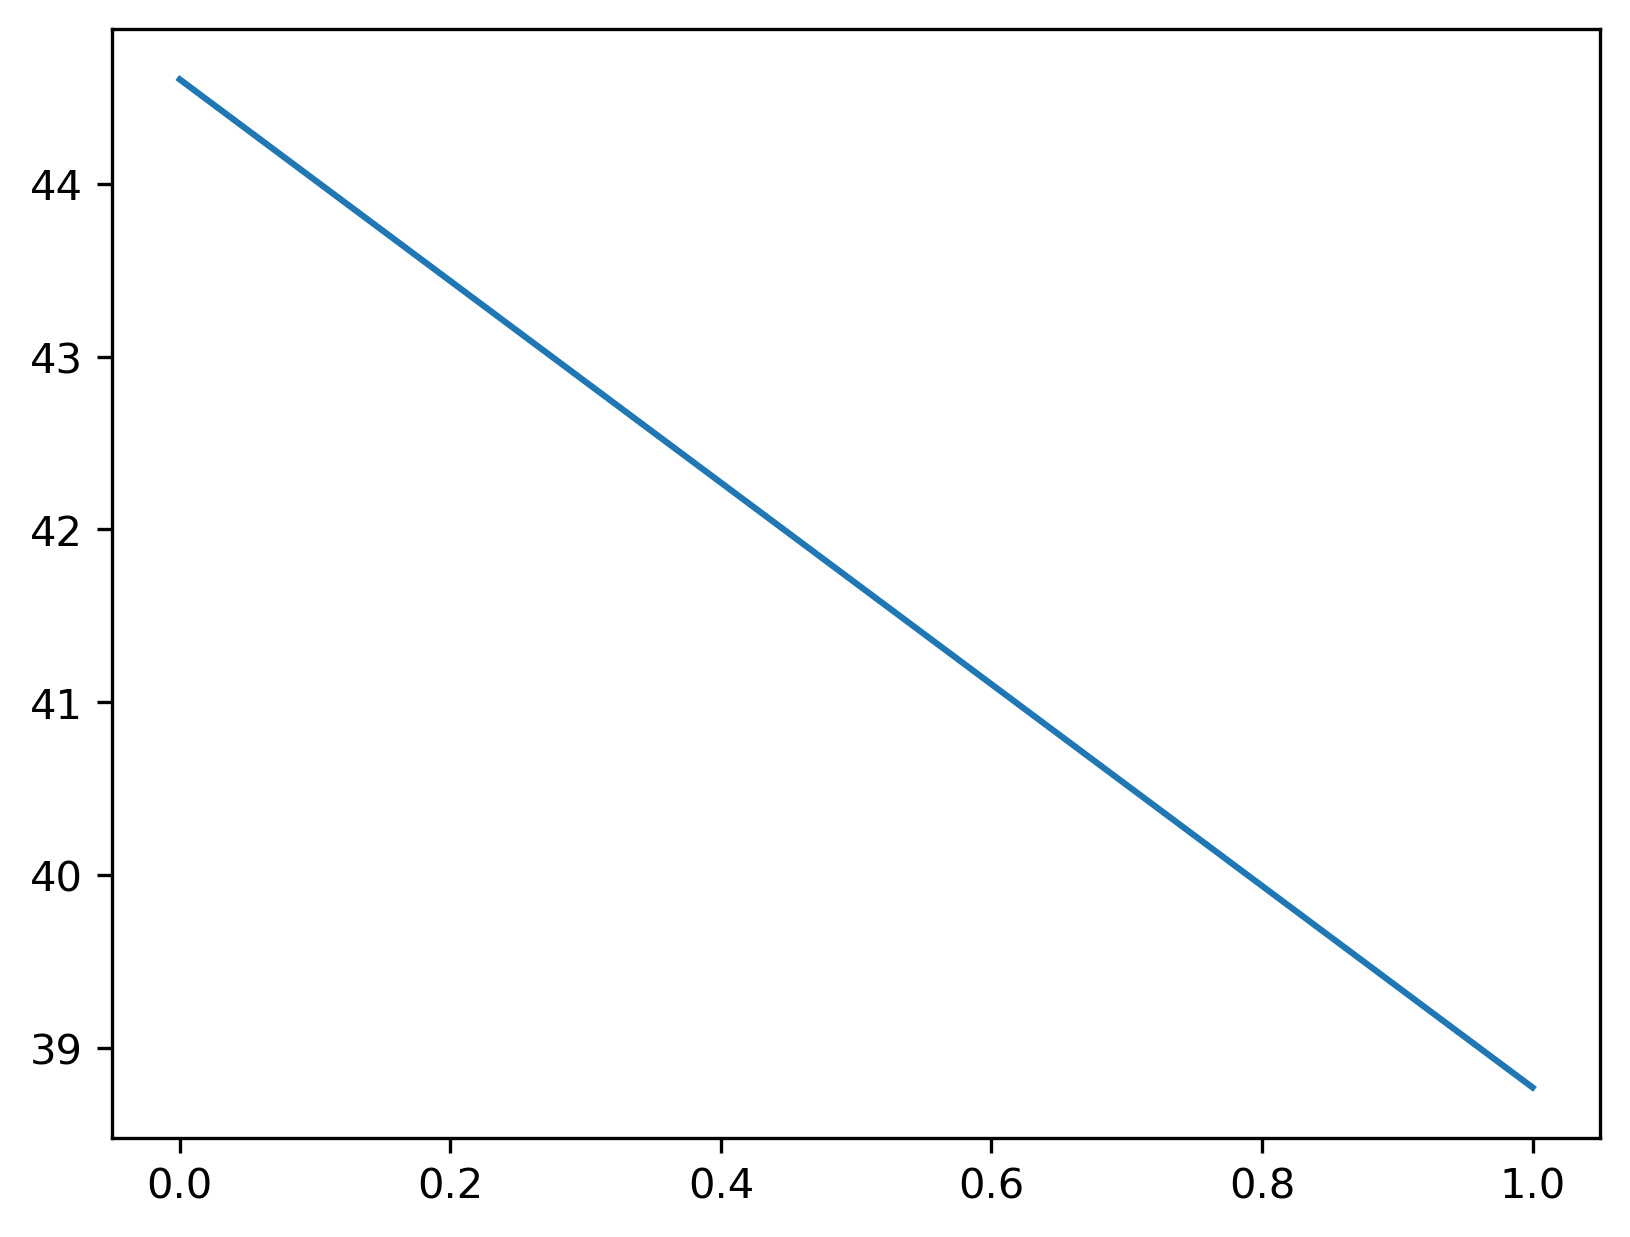

In [9]:
tot_history = history_.history['val_loss'] 
epochs = np.arange( 0, EPOCHS )

plt.plot( epochs, tot_history )
plt.show()

##  MODEL TESTING

In [10]:
reconstructed_model = models.load_model( 'training/'+filename, compile=False )

In [13]:
probability_model = Sequential([reconstructed_model])
#probability_model = tf.keras.Sequential([model])
predictions_best = probability_model.predict(x_test)

  9/474 [..............................] - ETA: 3s  

2023-07-08 19:24:29.306413: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


474/474 [==============================] - 3s 6ms/step


(0.0, 500000.0)

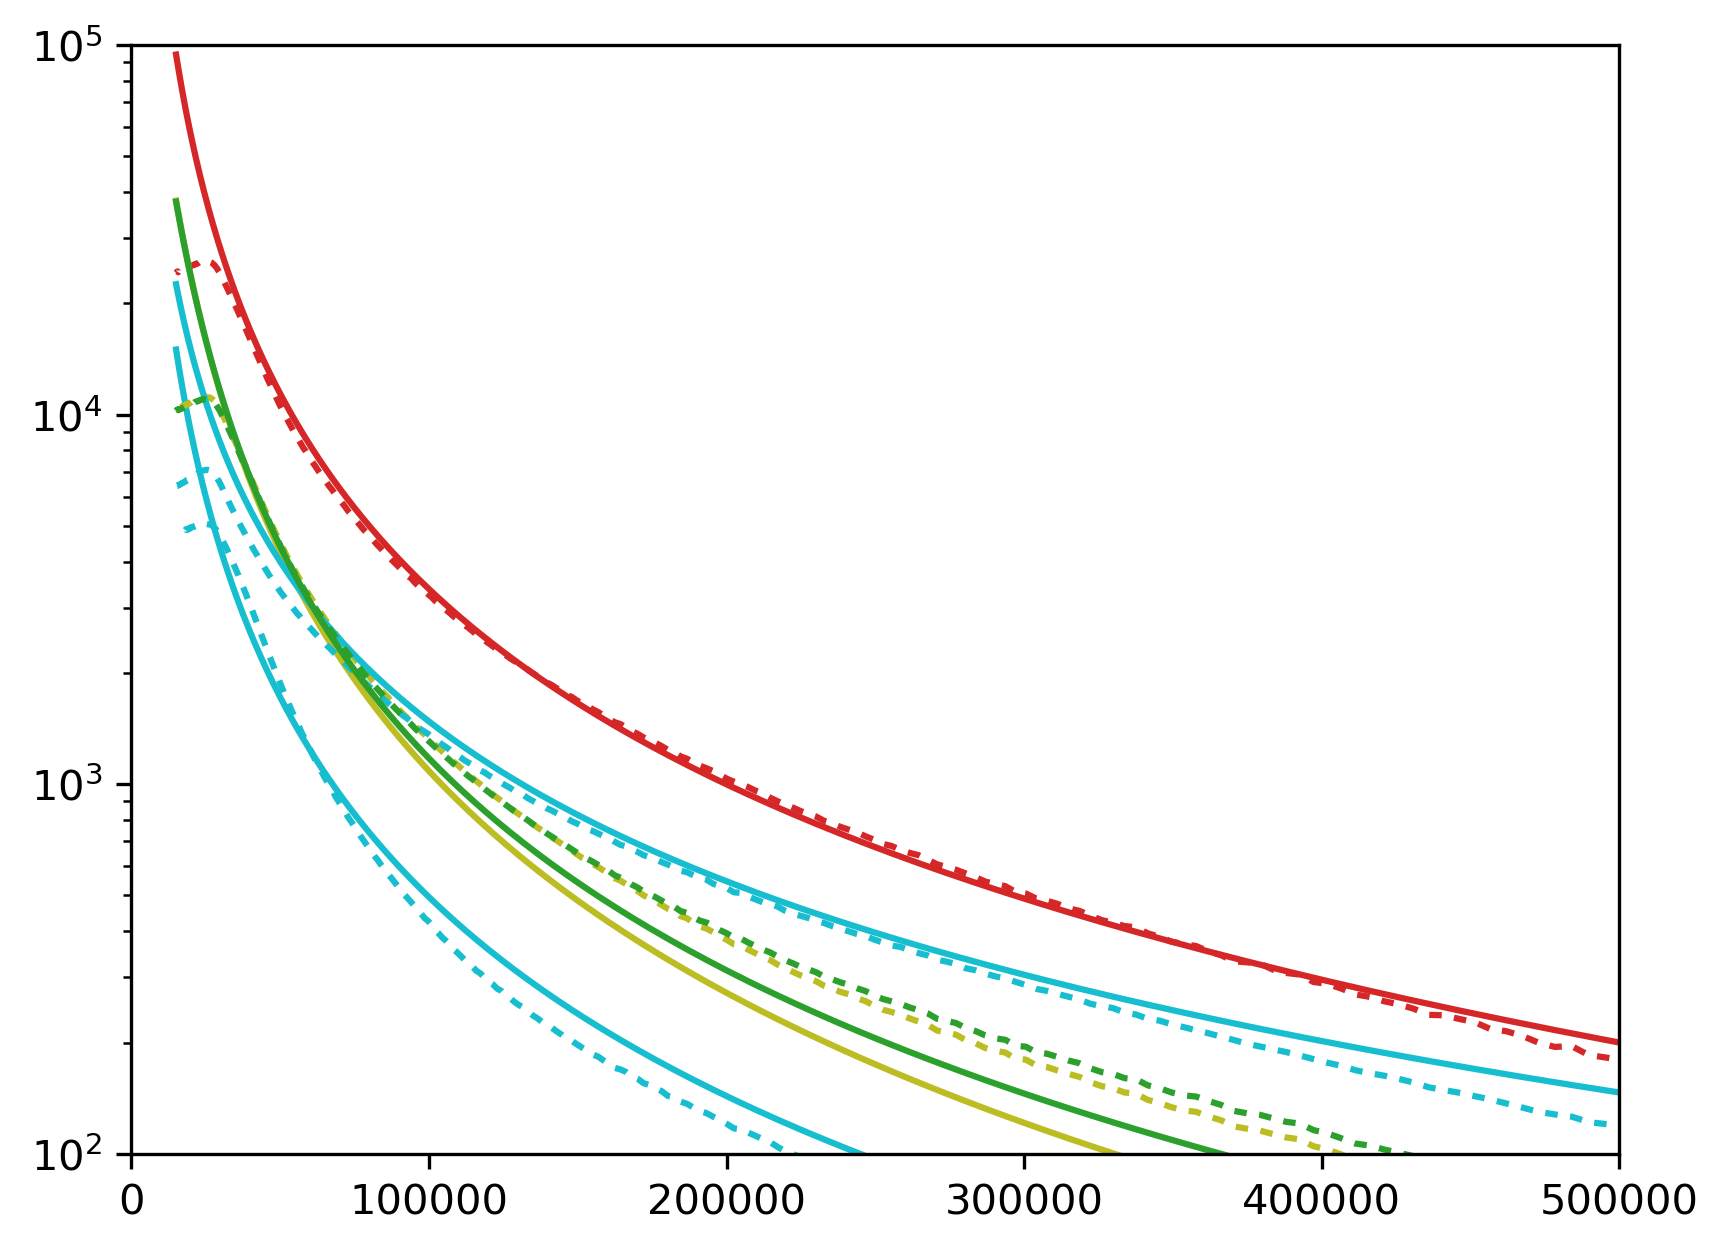

In [14]:
import matplotlib.pyplot as plt 
import matplotlib
matplotlib.rcParams['figure.dpi']=300

plt.subplot(1, 1, 1)
rand_set = np.random.randint( 0, y_test.shape[0] ,(5,) )
for i in rand_set:
    plt.plot(w_train, y_test[i,:],color='C'+str(i))
    plt.plot(w_train, predictions_best[i],dashes=[2,2,2,2],color='C'+str(i))
plt.yscale('log')
plt.ylim(1e2,1e5)
plt.xlim(0, 0.5e6)

In [ ]:
matplotlib.rcParams['figure.dpi']=300
plt.subplot(1, 2, 1)
rand_set = np.random.randint( 0, y_test.shape[0] ,(30,) )
for i in rand_set:
    plt.plot(w0,y_test[i,:],color='C'+str(i))
    #plt.plot(w0,predictions_best[i],dashes=[2,2,2,2],color='C'+str(i))
plt.yscale('log')

plt.subplot(1, 2, 2)
for i in rand_set:
    plt.plot( x_test[i,:],color='C'+str(i))
    #plt.plot(w0,predictions_best[i],dashes=[2,2,2,2],color='C'+str(i))